# Angaza Decision Scientist - "Homework" Responses

## Briefly document any observations about the data made during initial exploration / investigation.

In [439]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew as skew
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import scorecardpy as sc

#First, let's load the dataset

file_path = "/Users/Alex/Desktop/hw_table.csv"
df = pd.read_csv(file_path)

#And let's run some basic summary statistics first
summary_stats = df.describe()
summary_stats

,default_flag,var2,var3,var8,var9,var10,var12,var13,var14,var15,...,var33,var34,var35,var36,var37,var39,var40,var42,var43,loanid
count,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,...,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000
mean,0.189394,11.461039,64.599567,10.178571,147.873377,94.737554,4.816017,11.904762,514.778139,744.949134,...,77.079004,66.666126,116.417208,10393.765693,16.540043,12622.769481,3112.847787,0.359848,30.600649,924.500000
std,0.391927,1.851439,32.333064,22.104260,9.753107,18.276403,20.146156,30.720417,134.011569,4441.903284,...,131.645848,112.110673,179.275081,17335.360952,17.260027,21459.086786,6940.037951,0.480086,9.435079,533.615967
min,0.000000,1.000000,0.000000,0.000000,15.000000,25.000000,0.000000,0.000000,180.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-19.000000,0.000000,0.000000,1.000000
25%,0.000000,12.000000,40.000000,0.000000,150.000000,100.000000,0.000000,0.000000,410.000000,0.000000,...,16.000000,15.000000,9.000000,2000.000000,5.000000,1550.000000,0.000000,0.000000,24.000000,462.750000
50%,0.000000,12.000000,60.000000,0.000000,150.000000,100.000000,0.000000,0.000000,560.000000,0.000000,...,35.000000,30.000000,48.000000,5000.000000,12.000000,4880.000000,217.410000,0.000000,28.000000,924.500000
75%,0.000000,12.000000,80.000000,10.000000,150.000000,100.000000,0.000000,0.000000,600.000000,0.000000,...,75.000000,70.000000,145.000000,10500.000000,22.000000,12000.000000,4244.180000,1.000000,35.250000,1386.250000
max,1.000000,24.000000,160.000000,100.000000,150.000000,100.000000,100.000000,100.000000,840.000000,86286.000000,...,1257.000000,1050.000000,1905.000000,150000.000000,215.000000,150000.000000,139188.000000,1.000000,73.000000,1848.000000


Some basic stats: there are 1848 observations, and the mean for "default_flag" is 0.1894, meaning 18.94% of the loans in the dataset were defaulted on.

### A few observations

* There are quite a few right-skewed variables with a median/mode around 0 and a long right tail - around half the variables in the dataset. For a credit scoring dataset, it would make sense that this data represents spending, assets, or some other financial amount in a category. That would imply that many people do not spend or own something in that category, but some do (hence the long right tail).
* Much of the data appears to have been recorded in regular increments; for example, the values in var10 are either 0, 25, 50, 75, 100. These might be transformed into categorical data in the future.
* The two timestamp columns have very different distributions. Upon review, "var38" has quite a bit of missing data. 

In the annex, I transform the dataset so that the datatypes are all numerical. Then we can check for outliers.

### Analyzing the variables with outlier flags

In dealing with outlier variables, we can remove outliers or transform the data to improve the performance of our model.

The code for how I've flagged outliers is in the appendix.

In reviewing the outlier variables, there are a few cases here:
* Right skewed data with a long right tail: in this case most of the observations are clustered around 0, with a long tail of positive values. If the tail is long enough (range is large, but IQR is small) this is indicative of some outliers.

* Uneven bimodal or multimodal distributions: some of the boolean/dummy variables are very unevenly weighted, which results in them being flagged as outliers if there are relatively few True values.

# Which 7 features do you find to be the most predictive? Taking into consideration any multicollinearity (correlation amongst independent variables / features). Briefly explain your approach.

From here on I use a cleaned dataset called df_scaled, which I will attach and you can read through how I've generated in the related appendix.

Now let's look at the collinearity. First, I've done a visual inspection with a chart. Using the matrix below, you can see that there are some variables which are very highly correlated with one another.

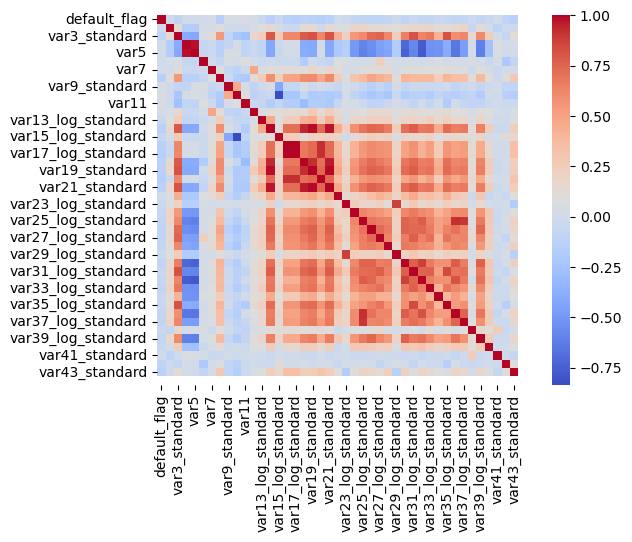

In [440]:
# Create a correlation matrix
correlation_matrix = df_scaled.corr()

# Create an empty dictionary to hold the collinear pairs and their correlation scores
collinear_pairs = {}

# Get only the upper triangle without diagonal
for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) >= 0.8:
            collinear_pairs[(correlation_matrix.columns[i], correlation_matrix.columns[j])] = correlation_matrix.iloc[i, j]

# I looked at the raw data with the following line, which you can uncomment to view           
# print("Collinear pairs with correlation scores: ", collinear_pairs)

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True)

# Show the plot
plt.show()

A cursory look at the CSV shows some of these columns are almost identical to each other.

I'll reduce the number of variables as follows: first I'll rank each pair by their correlation. Then I'll drop the one less correlated with the default_flag.

In [441]:
# Function to recursively drop highly correlated variables
def drop_highly_correlated(df, collinear_pairs, target):
    if len(collinear_pairs) == 0:
        return df
    
    # Sort the dictionary by absolute value of correlation in descending order
    sorted_pairs = sorted(collinear_pairs.items(), key=lambda x: abs(x[1]), reverse=True)

    # Find the pair with the highest correlation
    most_correlated_pair = sorted_pairs[0][0]

    # Calculate the correlation of each variable in the pair with the target variable
    corr_with_target = {var: df[var].corr(df[target]) for var in most_correlated_pair}

    # Find the variable that is least correlated with the target
    least_correlated_with_target = min(corr_with_target, key=lambda x: abs(corr_with_target[x]))


    # Drop this variable from the dataframe
    df = df.drop(columns=[least_correlated_with_target])

    # Remove all pairs that include this variable from the dictionary
    collinear_pairs = {pair: corr for pair, corr in collinear_pairs.items() if least_correlated_with_target not in pair}

    return drop_highly_correlated(df, collinear_pairs, target)

# Call the function to drop highly correlated variables
df_reduced = drop_highly_correlated(df_scaled, collinear_pairs, 'default_flag')

correlation_matrix_reduced = df_reduced.corr()

# Uncomment the following two lines to plot the correlation matrix as a heatmap
# sns.heatmap(correlation_matrix_reduced, annot=False, cmap='coolwarm', square=True)
# plt.show()

In [448]:
# Finally, let's use scorecardpy to get the information value of each of these variables and rank the top 7:

# Use scorecardpy's built-in filtering to eliminate variables with low information value
dt_s = sc.var_filter(df_reduced, y="default_flag")

# Generate a table of information values in a dataframe
iv_table = sc.iv(dt_s, y="default_flag")

# Show the top 7 variables
iv_table.head(7)

[INFO] filtering variables ...


,variable,info_value
16,var26_log_standard,0.562698
11,var30_log_standard,0.555719
3,var28_log_standard,0.544285
12,var33_log_standard,0.519470
9,var39_log_standard,0.500122
0,var27_log_standard,0.485209
1,var22_log_standard,0.480458


# Choose any of your top features / variables and present a graph illustrating banding of the variable with bad rate (default rate) and volumes. What is the Information Value of this variable / feature? How did you arrive at this value?

See the below code and chart. I used the ScorecardPy library to create bins and a weight of information for the top variable, var_26_log_standard. This creates bins that maximize the we

For this variable, the data is normally distributed (since we've normalized it). The majority of the mass of defaulters have a below average score; those in the top bin (which will be about 35% of the observations) rarely default.

[INFO] creating woe binning ...


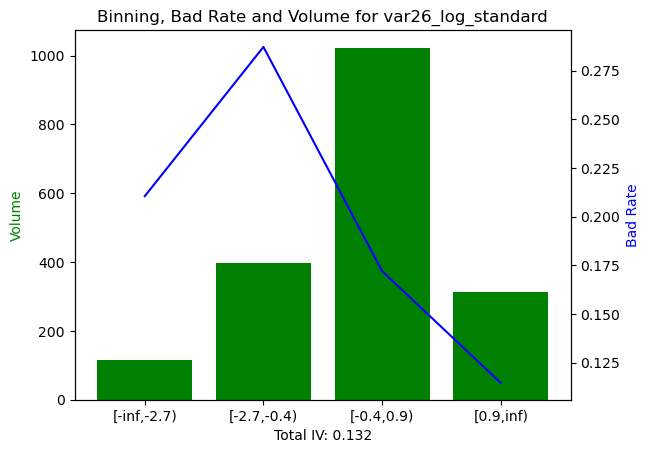

In [444]:


# The next part is for readability of the plot
# Extracting lower bound values
bin_df['lower_bound'] = bin_df['bin'].str.extract(r'\[([^,]+),')

# Extracting upper bound values
bin_df['upper_bound'] = bin_df['bin'].str.extract(r',([^)]+)\)')

# Converting columns to appropriate data types
bin_df['lower_bound'] = pd.to_numeric(bin_df['lower_bound'], errors='coerce').round(2)
bin_df['upper_bound'] = pd.to_numeric(bin_df['upper_bound'], errors='coerce').round(2)

# Updating the bin column by combining lower_bound and upper_bound
bin_df['bin'] = '[' + bin_df['lower_bound'].astype(str) + ',' + bin_df['upper_bound'].astype(str) + ')'

# Plotting the chart

fig, ax1 = plt.subplots()

# Define the axes and plot types
ax2 = ax1.twinx()
ax1.bar(bin_df['bin'].astype(str), bin_df['count'], color='g')
ax2.plot(bin_df['bin'].astype(str), bin_df['badprob'], color='b')

# Set the labels
ax1.set_xlabel('Total IV: ' + bin_df["bin_iv"].round(3).sum().astype(str))
ax1.set_ylabel('Volume', color='g')
ax2.set_ylabel('Bad Rate', color='b')

plt.title('Binning, Bad Rate and Volume for {}'.format(var_name))
plt.show()

# Present the distribution of your final score and provide the scaling information.

Below I train the model using a logistic regression model and then plot the distribution of defaulters and non-defaulters in a histogram.

The scores follow a range of 300 to 850, as follows the US credit scoring system, but this could be scaled to any value range.

In [451]:
# split your data into training and testing sets
train, test = train_test_split(dt_s, test_size=0.3, random_state=42) # change test_size to the desired split ratio

train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)

y_train = train_woe.loc[:,'default_flag']
X_train = train_woe.loc[:,train_woe.columns != 'default_flag']
y_test = test_woe.loc[:,'default_flag']
X_test = test_woe.loc[:,test_woe.columns != 'default_flag']

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)

# predicted class
train_pred_class = lr.predict(X_train)
test_pred_class = lr.predict(X_test)

# accuracy
train_accuracy = metrics.accuracy_score(y_train, train_pred_class)
test_accuracy = metrics.accuracy_score(y_test, test_pred_class)

print("Train accuracy: ", train_accuracy)
print("Test accuracy: ", test_accuracy)

# Generate Scorecard
card = sc.scorecard(bins, lr, X_train.columns)

# Generate credit scores for the original dataset
dt_s = dt_s.assign(credit_score = sc.scorecard_ply(dt_s, card, print_step=0))

card_df = pd.concat(card.values(), ignore_index=True)

[INFO] converting into woe values ...
[INFO] converting into woe values ...
Train accuracy:  0.8081979891724671
Test accuracy:  0.8162162162162162


/Users/alex/anaconda3/lib/python3.10/site-packages/scorecardpy/scorecard.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_score.loc[:,'score'] = card_basepoints + dat_score.sum(axis=1)


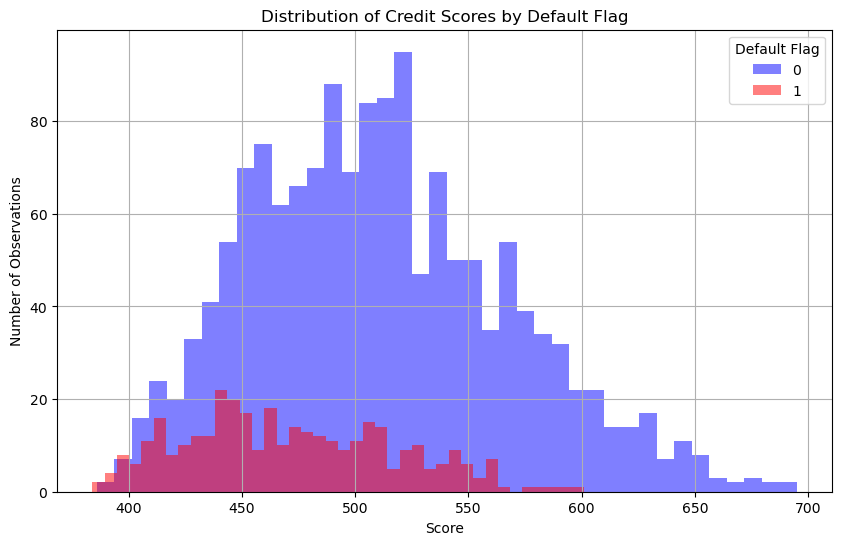

In [465]:
plt.figure(figsize=(10, 6))
colors = ["blue", "red"]

# Create histograms for each category of 'default_flag'
for default_flag, color in zip(dt_s['default_flag'].unique(), colors):
    subset = dt_s[dt_s['default_flag'] == default_flag]
    plt.hist(subset['credit_score'], bins=40, alpha=0.5, label=str(default_flag), color=color)

plt.title('Distribution of Credit Scores by Default Flag')
plt.xlabel('Score')
plt.ylabel('Number of Observations')
plt.grid(True)
plt.legend(title='Default Flag')
plt.show()


# What is the default rate of the sample set? Using the sample set, what will your score cut-off be to reduce the default rate to 12%? Briefly explain your approach.

As mentioned before, the default rate is 18.94% in the full dataset.

As the scores get lower (worse), there will be more defaulters in the dataset. Below I calculate a score cutoff by working my way down the dataset from best to worst until the default rate reaches 12%. 

In [454]:
# Step 1: Sort your dataset by these probabilities in descending order
dt_s = dt_s.sort_values(by='credit_score', ascending=False)

# Step 2: Start summing up the actual defaults until the ratio of sum of defaults and total instances reaches 12%
cum_defaults = dt_s['default_flag'].cumsum()
total_defaults = dt_s['default_flag'].sum()

dt_s['default_ratio'] = cum_defaults / (np.arange(len(dt_s)) + 1)

# Find the first index where the ratio of cumulative defaults to total instances is less than or equal to 12%
index_threshold = default_ratio[default_ratio <= 0.12].index[-1]

# The maximum score in the data above this point is the threshold score
threshold_row = dt_s[dt_s['default_ratio'] >= 0.12].iloc[0]

threshold_score = threshold_row['credit_score']

print('The threshold score is: ', threshold_score)

# Show stats above and below the threshold
obs_above_threshold = dt_s[dt_s['credit_score'] >= threshold_score].shape[0]
defaults_above_threshold = dt_s[(dt_s['credit_score'] >= threshold_score) & (dt_s['default_flag'] == 1)].shape[0]

obs_below_threshold = dt_s[dt_s['credit_score'] < threshold_score].shape[0]
defaults_below_threshold = dt_s[(dt_s['credit_score'] < threshold_score) & (dt_s['default_flag'] == 1)].shape[0]

print('Number of observations above the threshold: ', obs_above_threshold)
print('Number of defaults above the threshold: ', defaults_above_threshold)
print('Default ratio above the threshold: ', defaults_above_threshold / obs_above_threshold)

print('Number of observations below the threshold: ', obs_below_threshold)
print('Number of defaults below the threshold: ', defaults_below_threshold)
print('Default ratio below the threshold: ', defaults_below_threshold / obs_below_threshold if obs_below_threshold > 0 else np.nan)


The threshold score is:  483.0
Number of observations above the threshold:  1130
Number of defaults above the threshold:  137
Default ratio above the threshold:  0.12123893805309735
Number of observations below the threshold:  718
Number of defaults below the threshold:  213
Default ratio below the threshold:  0.2966573816155989


# Please produce a model artifact / scorecard logic here or you can submit it in a separate file.

In [469]:
# This will output the scorecard logic to a .csv file.

card_df.to_csv("scorecard.csv")